In [1]:
using CSV
using DataFrames
using Dates
using Plots
using JuMP
using Gurobi

In [16]:
run_name = "low_RE_high_elec_iter0_default";
climate_scenario = "historical_1980_2019";
sim_year = 1982;
busprop_name = "boyuan";
branchprop_name = "boyuan";
if_lim_name = "vivienne_2023_paper";
exclude_external_zones = true;
include_new_hvcd = false;
save_name = "nyiso_only"

"nyiso_only"

In [17]:
include("./src/julia/utils.jl");
include("./src/julia/dcopf.jl");

In [18]:
run_model(
    run_name,
    climate_scenario,
    sim_year,
    branchprop_name,
    busprop_name,
    if_lim_name,
    save_name,
)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2677362
Academic license 2677362 - for non-commercial use only - registered to dc___@cornell.edu
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "CentOS Linux 8")

CPU model: Intel(R) Xeon(R) Gold 5218R CPU @ 2.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 40 physical cores, 80 logical processors, using up to 32 threads

Academic license 2677362 - for non-commercial use only - registered to dc___@cornell.edu
Optimize a model with 4957582 rows, 6577901 columns and 13907554 nonzeros
Model fingerprint: 0x73da5e86
Coefficient statistics:
  Matrix range     [9e-01, 2e+04]
  Objective range  [1e+00, 1e+04]
  Bounds range     [2e-04, 1e+05]
  RHS range        [3e-05, 4e+05]
Presolve removed 234750 rows and 410000 columns (presolve time = 6s)...
Presolve removed 4511657 rows and 4686907 columns (presolve time = 10s)...
Presolve removed 4511657 rows and 4862258 columns
Presolve time: 12.

LoadError: IOError: mkdir("/home/fs01/dcl257/projects/acorn-julia/runs/low_RE_high_elec_iter0_default/outputs/historical_1980_2019/nyiso_only"; mode=0o777): no such file or directory (ENOENT)

In [2]:
# Specify run directory
run_name = "low_RE_high_elec_iter0_default";
run_directory = "/home/fs01/dcl257/projects/acorn-julia/runs/$(run_name)";

# Project data directory
data_directory = "/home/fs01/dcl257/projects/acorn-julia/data";

# Year of run
sim_year = 1982;

In [3]:
# # Read the load
# climate_scenario = "historical_1980_2019"
# load = CSV.read("$(run_directory)/inputs/load_$(climate_scenario).csv", DataFrame);

# # Read generation
# solar_upv = CSV.read("$(run_directory)/inputs/solar_upv_$(climate_scenario).csv", DataFrame);
# wind = CSV.read("$(run_directory)/inputs/wind_$(climate_scenario).csv", DataFrame);
# solar_dpv = CSV.read("$(run_directory)/inputs/solar_dpv_$(climate_scenario).csv", DataFrame);

# # Read hydro
# hydro_scenario = "historical"
# large_hydro = CSV.read("$(run_directory)/inputs/large_hydro_$(hydro_scenario).csv", DataFrame);
# small_hydro = CSV.read("$(run_directory)/inputs/small_hydro_$(hydro_scenario).csv", DataFrame);

# # Read storage
# storage = CSV.read("$(run_directory)/inputs/storage_assignment.csv", DataFrame);

In [50]:
split(climate_scenario, "_")[1]

"historical"

In [4]:
# # Read generators
# genprop_nuclear = CSV.read("$(run_directory)/inputs/genprop_nuclear_matched.csv", DataFrame, stringtype=String);
# genprop_ng = CSV.read("$(run_directory)/inputs/genprop_ng_matched.csv", DataFrame, stringtype=String);
# genprop_hydro = CSV.read("$(run_directory)/inputs/genprop_hydro.csv", DataFrame, stringtype=String);
# genprop = vcat(genprop_nuclear, genprop_ng, genprop_hydro);

# # Read bus data
# busprop_name = "boyuan"
# busprop = CSV.read("$(data_directory)/grid/bus_prop_$(busprop_name).csv", DataFrame);
# bus_ids = busprop[:, "BUS_I"]

# # Read branch data
# branchprop_name = "boyuan"
# branchprop = CSV.read("$(data_directory)/grid/branch_prop_$(branchprop_name).csv", DataFrame);

In [77]:
include("./src/julia/utils.jl");

In [6]:
# Fill the missing load buses with zero (external ones)
load = leftjoin(DataFrame(bus_id = bus_ids), load, on = :bus_id)
load = coalesce.(load, 0.0);
load = sort(load, [:bus_id]);
load = max.(load, 0);

In [7]:
# # Subtract small solar 
# load = subtract_solar_dpv(load, solar_dpv, sim_year);
# # Subtract small hydro
# load = subtract_small_hydro(load, small_hydro, sim_year);

In [10]:
# # Get dates
# sim_dates = names(load)[2:end]
# nt = length(sim_dates);

In [11]:
# load_data = Matrix(load[:, sim_dates]);

In [12]:
# #########################
# # SUBTRACT EXTERNAL ZONES
# #########################
# external_buses = [21, 29, 35, 100, 102, 103, 124, 125, 132, 134, 138];

# # Buses
# busprop = busprop[findall(.!in(external_buses), busprop.BUS_I), :];
# bus_ids = busprop[:, "BUS_I"]

# # Branches
# branchprop = branchprop[findall(.!in(external_buses), branchprop.F_BUS), :];
# branchprop = branchprop[findall(.!in(external_buses), branchprop.T_BUS), :];

In [13]:
# # Add solar and wind generators
# wind_bus_ids = wind[:, "bus_id"]
# genprop = add_wind_generators(genprop, wind_bus_ids);

# solar_upv_bus_ids = solar_upv[:, "bus_id"]
# genprop = add_solar_generators(genprop, solar_upv_bus_ids);

In [12]:
# # Add HVDC generators
# genprop = add_hvdc_generators(genprop, false);

In [14]:
# Get dates
sim_dates = names(load)[2:end]
nt = length(sim_dates);

In [15]:
# # Get generator limits
# g_max = repeat(genprop[:, "PMAX"], 1, nt); # Maximum real power output (MW)
# g_min = repeat(genprop[:, "PMIN"], 1, nt); # Minimum real power output (MW)

In [16]:
# # Update for renewables
# wind_idx = findall(x -> x == "Wind", genprop[:, "UNIT_TYPE"])
# g_max[wind_idx, :] .= wind[:, sim_dates];

# solar_upv_idx = findall(x -> x == "SolarUPV", genprop[:, "UNIT_TYPE"])
# g_max[solar_upv_idx, :] .= solar_upv[:, sim_dates];

In [17]:
# # Get generator ramp rates
# ramp_down = max.(repeat(genprop[:, "RAMP_30"], 1, nt) .* 2, repeat(genprop[:, "PMAX"], 1, nt)) # max of 2*RAMP_30, PMAX
# ramp_up = copy(ramp_down);

In [18]:
# # Generator cost
# gencost = repeat(genprop[:, "COST_1"], 1, nt); # Cost per unit power generated

In [19]:
# # Read interface limits
# if_lim_name = "vivienne_2023_paper"
# if_lims = CSV.read("$(data_directory)/nyiso/interface_limits/if_lim_$(if_lim_name).csv", DataFrame);

# ############################
# # SUBTRACT EXTERNAL ZONES
# ############################
# external_zones = ["NE", "IESO", "PJM"]
# if_lims = if_lims[findall(.!in(external_zones), if_lims.FROM_ZONE), :];
# if_lims = if_lims[findall(.!in(external_zones), if_lims.TO_ZONE), :];

# if_lim_up = repeat(if_lims[:, "IF_MAX"], 1, nt);
# if_lim_down = repeat(if_lims[:, "IF_MIN"], 1, nt);

# # Get IF lim map and update branchprop
# if_lim_map, branchprop = create_interface_map(if_lims, branchprop);

In [20]:
# # Branch limits
# branch_lims = repeat(Float64.(branchprop[:, "RATE_A"]), 1, nt)
# branch_lims[branch_lims.==0] .= 99999.0;

In [21]:
# # Get storage info
# storage_bus_ids = storage[:, "bus_id"];
# storage_charge_cap = repeat(storage[:, "charge_capacity_MW"], 1, nt);
# storage_energy_cap = repeat(storage[:, "storage_capacity_mwh"], 1, nt+1);

In [22]:
# ########## Optimization ##############
# n_gen = size(genprop, 1)
# n_bus = size(busprop, 1)
# n_branch = size(branchprop, 1)

# model = Model(Gurobi.Optimizer)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2677362
Academic license 2677362 - for non-commercial use only - registered to dc___@cornell.edu


A JuMP Model
├ solver: Gurobi
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

In [23]:
# # Define variables
# @variable(model, pg[1:n_gen, 1:nt])
# @variable(model, flow[1:n_branch, 1:nt])
# @variable(model, bus_angle[1:n_bus, 1:nt])
# @variable(model, charge[1:length(storage_bus_ids), 1:nt])
# @variable(model, discharge[1:length(storage_bus_ids), 1:nt])
# @variable(model, batt_state[1:length(storage_bus_ids), 1:nt+1])
# @variable(model, load_shedding[1:n_bus, 1:nt])

46×8759 Matrix{VariableRef}:
 load_shedding[1,1]   load_shedding[1,2]   …  load_shedding[1,8759]
 load_shedding[2,1]   load_shedding[2,2]      load_shedding[2,8759]
 load_shedding[3,1]   load_shedding[3,2]      load_shedding[3,8759]
 load_shedding[4,1]   load_shedding[4,2]      load_shedding[4,8759]
 load_shedding[5,1]   load_shedding[5,2]      load_shedding[5,8759]
 load_shedding[6,1]   load_shedding[6,2]   …  load_shedding[6,8759]
 load_shedding[7,1]   load_shedding[7,2]      load_shedding[7,8759]
 load_shedding[8,1]   load_shedding[8,2]      load_shedding[8,8759]
 load_shedding[9,1]   load_shedding[9,2]      load_shedding[9,8759]
 load_shedding[10,1]  load_shedding[10,2]     load_shedding[10,8759]
 load_shedding[11,1]  load_shedding[11,2]  …  load_shedding[11,8759]
 load_shedding[12,1]  load_shedding[12,2]     load_shedding[12,8759]
 load_shedding[13,1]  load_shedding[13,2]     load_shedding[13,8759]
 ⋮                                         ⋱  
 load_shedding[35,1]  load_shedding[

In [24]:
# ## Constraints 
# # Branch flow limits and power flow equations
# for l in 1:n_branch
#     idx_from_bus = findfirst(x -> x == branchprop[l, "F_BUS"], busprop[:, "BUS_I"])
#     idx_to_bus = findfirst(x -> x == branchprop[l, "T_BUS"], busprop[:, "BUS_I"])
#     # Branch flow limits
#     @constraint(model, -branch_lims[l, :] .<= flow[l, :] .<= branch_lims[l, :])
#     # DC power flow equations
#     @constraint(model, flow[l, :] .== (100 / branchprop[l, "BR_X"]) .* 
#         (bus_angle[idx_from_bus, :] .- bus_angle[idx_to_bus, :]))
#     end

In [25]:
# # Node balance and phase angle constraints
# for idx in 1:n_bus
#     bus_id = bus_ids[idx]
#     if busprop[idx, "BUS_TYPE"] != 3  # Not the slack bus
#         if bus_id in storage_bus_ids
#             # Node balance with storage devices
#             storage_idx = findfirst(==(bus_id), storage_bus_ids)
#             @constraint(model, load_data[idx, 1:nt] .==
#                                -sum(flow[l, 1:nt] for l in findall(x -> x == bus_id, branchprop[:, "F_BUS"])) .+
#                                sum(flow[l, 1:nt] for l in findall(x -> x == bus_id, branchprop[:, "T_BUS"])) .+
#                                sum(pg[l, 1:nt] for l in findall(x -> x == bus_id, genprop[:, "GEN_BUS"])) .+
#                                discharge[storage_idx, 1:nt] .-
#                                charge[storage_idx, 1:nt] .+
#                                load_shedding[idx, 1:nt])
#         else
#             # Node balance without storage devices
#             @constraint(model, load_data[idx, 1:nt] .==
#                                -sum(flow[l, 1:nt] for l in findall(x -> x == bus_id, branchprop[:, "F_BUS"])) .+
#                                sum(flow[l, 1:nt] for l in findall(x -> x == bus_id, branchprop[:, "T_BUS"])) .+
#                                sum(pg[l, 1:nt] for l in findall(x -> x == bus_id, genprop[:, "GEN_BUS"])) .+
#                                load_shedding[idx, 1:nt])
#         end
#         @constraint(model, -2 * pi .<= bus_angle[idx, 1:nt] .<= 2 * pi)  # Voltage angle limits
#     else  # Slack bus
#         # Node balance for slack bus
#         @constraint(model, load_data[idx, 1:nt] .==
#                            -sum(flow[l, 1:nt] for l in findall(x -> x == bus_id, branchprop[:, "F_BUS"])) .+
#                            sum(flow[l, 1:nt] for l in findall(x -> x == bus_id, branchprop[:, "T_BUS"])) .+
#                            sum(pg[l, 1:nt] for l in findall(x -> x == bus_id, genprop[:, "GEN_BUS"])) .+
#                            load_shedding[idx, 1:nt])
#         @constraint(model, bus_angle[idx, 1:nt] .== 0.2979 / 180 * pi)  # Fix voltage angle at slack bus
#     end
# end

In [26]:
# # Storage constraints
# @constraint(model, 0 .<= charge .<= storage_charge_cap);         # Charging limits
# @constraint(model, 0 .<= discharge .<= storage_charge_cap);      # Discharging limits

In [27]:
# # Battery state dynamics for all time steps
# storage_eff = 0.75;
# for t in 1:nt
#     # Battery state dynamics for all but the last storage bus
#     @constraint(model, batt_state[1:end, t+1] .== batt_state[1:end, t] .+ sqrt(storage_eff) .* charge[1:end, t] .- (1 / sqrt(storage_eff)) .* discharge[1:end, t])

#     # NEED TO UPDATE THIS!
#     # # Battery state dynamics Gilboa
#     # @constraint(model, batt_state[end, t+1] .== batt_state[end, t] .+ sqrt(gilboa_eff) .* charge[end, t] .- (1 / sqrt(gilboa_eff)) .* discharge[end, t])
# end

In [28]:
# # Battery capacity constraints
# @constraint(model, 0.0 .* storage_energy_cap .<= batt_state .<= storage_energy_cap);

In [29]:
# # Initial battery state (assuming 30% of capacity)
# @constraint(model, batt_state[:, 1] .== 0.3 .* storage_energy_cap[:, 1]);

In [30]:
# # Impose interface limits
# n_if_lims = size(if_lim_up)[1];

# for i in 1:n_if_lims
#     # Sum flow across the interfaces
#     branch_idx = if_lim_map[findall(==(i), if_lim_map[:, "IF_ID"]), "BR_IDX"];
#     idx_signs = sign.(branch_idx);
#     idx_abs = abs.(branch_idx);

#     flow_sum = [sum(idx_signs .* flow[Int.(idx_abs), t]) for t in 1:nt]
#     # Constraint
#     @constraint(model, if_lim_down[i, 1:nt] .<= flow_sum .<= if_lim_up[i, 1:nt])
# end

In [31]:
# # Nuclear generators always fully dispatch
# nuclear_idx = findall(x -> x == "Nuclear", genprop[!, "UNIT_TYPE"])
# for idx in nuclear_idx
#     @constraint(model, pg[idx, :] .== g_max[idx, :])
# end

In [32]:
# # Hydro generators always fully dispatch at a weekly timescale
# niagara_idx = findfirst(x -> x == "Moses Niagara (Fleet)", genprop[!, "GEN_NAME"]);
# moses_saund_idx = findfirst(x -> x == "St Lawrence - FDR (Fleet)", genprop[!, "GEN_NAME"]);

In [33]:
# # Hydro
# moses_saund_hydro = Matrix(filter_by_year(large_hydro, sim_year))[1, 2:end];
# niagra_hydro = Matrix(filter_by_year(large_hydro, sim_year))[2, 2:end];

# # Calculate the capacity rate of Moses Saunders
# hydro_pmax = genprop[moses_saund_idx, "PMAX"]
# hours_in_week = 24*7
# cap_rate = maximum(moses_saund_hydro ./ hours_in_week / hydro_pmax)
# if cap_rate > 1
#     g_max[moses_saund_idx, :] .= g_max[moses_saund_idx, :] .* cap_rate
# end

# # Calculate the capacity rate of Niagara
# hydro_pmax = genprop[niagara_idx, "PMAX"]
# hours_in_week = 24*7
# cap_rate = maximum(niagra_hydro ./ hours_in_week / hydro_pmax)
# if cap_rate > 1
#     g_max[niagara_idx, :] .= g_max[niagara_idx, :] .* cap_rate
# end

In [34]:
# # Do manually for now, update latyer
# weekly_hours = vcat(fill(7*24, 52), [7]);

In [35]:
# # Cumulative time counter
# ct = 0
# for t in 1:48
#     # Add constraints for generator power sum
#     @constraint(model, sum(pg[niagara_idx, ct+1:ct+weekly_hours[t]]) == niagra_hydro[t])
#     @constraint(model, sum(pg[moses_saund_idx, ct+1:ct+weekly_hours[t]]) == moses_saund_hydro[t])
#     ct += weekly_hours[t]
# end

In [36]:
new_hvdc = false;

In [37]:
# # Generator capacity constraints
# @constraint(model, g_min .<= pg .<= g_max)

# # # HVDC constraints (modelled as two dummy generators on each side of the lines)
# # csc_idx = findall(x -> x == "HVDC_CSC", genprop[!, "GEN_NAME"])
# # @constraint(model, pg[csc_idx[1], :] .== -pg[csc_idx[2], :]) # SC+NPX1385

# # neptune_idx = findall(x -> x == "HVDC_Neptune", genprop[!, "GEN_NAME"])
# # @constraint(model, pg[neptune_idx[1], :] .== -pg[neptune_idx[2], :]) # Neptune

# # vft_idx = findall(x -> x == "HVDC_VFT", genprop[!, "GEN_NAME"])
# # @constraint(model, pg[vft_idx[1], :] .== -pg[vft_idx[2], :]) # VFT

# # htp_idx = findall(x -> x == "HVDC_HTP", genprop[!, "GEN_NAME"])
# # @constraint(model, pg[htp_idx[1], :] .== -pg[htp_idx[2], :]) # HTP

# if new_hvdc
#     clean_path_idx = findall(x -> x == "HVDC_NYCleanPath", genprop[!, "GEN_NAME"])
#     @constraint(model, pg[clean_path_idx[1], :] .== -pg[clean_path_idx[2], :]) # CleanPath

#     chp_express_idx = findall(x -> x == "HVDC_CHPexpress", genprop[!, "GEN_NAME"])
#     @constraint(model, pg[chp_express_idx[1], :] .== -pg[chp_express_idx[2], :]) # CHP Express
# end

# # Generator ramping constraints
# @constraint(model, -ramp_down[:, 2:nt] .<= pg[:, 2:nt] .- pg[:, 1:nt-1] .<= ramp_up[:, 2:nt]);

124×8758 Matrix{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.Interval{Float64}}, ScalarShape}}:
 -pg[1,1] + pg[1,2] ∈ [-858.9, 858.9]      …  -pg[1,8758] + pg[1,8759] ∈ [-858.9, 858.9]
 -pg[2,1] + pg[2,2] ∈ [-630.5, 630.5]         -pg[2,8758] + pg[2,8759] ∈ [-630.5, 630.5]
 -pg[3,1] + pg[3,2] ∈ [-1246.6, 1246.6]       -pg[3,8758] + pg[3,8759] ∈ [-1246.6, 1246.6]
 -pg[4,1] + pg[4,2] ∈ [-74, 74]               -pg[4,8758] + pg[4,8759] ∈ [-74, 74]
 -pg[5,1] + pg[5,2] ∈ [-71, 71]               -pg[5,8758] + pg[5,8759] ∈ [-71, 71]
 -pg[6,1] + pg[6,2] ∈ [-149, 149]          …  -pg[6,8758] + pg[6,8759] ∈ [-149, 149]
 -pg[7,1] + pg[7,2] ∈ [-237, 237]             -pg[7,8758] + pg[7,8759] ∈ [-237, 237]
 -pg[8,1] + pg[8,2] ∈ [-363, 363]             -pg[8,8758] + pg[8,8759] ∈ [-363, 363]
 -pg[9,1] + pg[9,2] ∈ [-546, 546]             -pg[9,8758] + pg[9,8759] ∈ [-546, 546]
 -pg[10,1] + pg[10,2] ∈ [-296, 296]           -pg[10,87

In [38]:
# Load shedding constraints
@constraint(model, 0.0 .<= load_shedding .<= max.(load_data, 0));

In [39]:
# Extract generation for wind and calculate curtailment
wind_gen = pg[wind_idx, :]
wind_curt = Matrix(wind[:, sim_dates]) .- wind_gen

# Extract generation for utility-scale solar (UPV) and calculate curtailment
solar_gen = pg[solar_upv_idx, :]
solar_curt = Matrix(solar_upv[:, sim_dates]) .- solar_gen

9×8759 Matrix{AffExpr}:
 -pg[116,1]  -pg[116,2]  -pg[116,3]  …  -pg[116,8758]  -pg[116,8759]
 -pg[117,1]  -pg[117,2]  -pg[117,3]     -pg[117,8758]  -pg[117,8759]
 -pg[118,1]  -pg[118,2]  -pg[118,3]     -pg[118,8758]  -pg[118,8759]
 -pg[119,1]  -pg[119,2]  -pg[119,3]     -pg[119,8758]  -pg[119,8759]
 -pg[120,1]  -pg[120,2]  -pg[120,3]     -pg[120,8758]  -pg[120,8759]
 -pg[121,1]  -pg[121,2]  -pg[121,3]  …  -pg[121,8758]  -pg[121,8759]
 -pg[122,1]  -pg[122,2]  -pg[122,3]     -pg[122,8758]  -pg[122,8759]
 -pg[123,1]  -pg[123,2]  -pg[123,3]     -pg[123,8758]  -pg[123,8759]
 -pg[124,1]  -pg[124,2]  -pg[124,3]     -pg[124,8758]  -pg[124,8759]

In [40]:
# Objective function: Minimize load shedding and storage operation costs
@objective(model, Min, 100000 * sum(load_shedding) + (sum(charge) + sum(discharge)) + sum(gencost .* pg))

100000 load_shedding[1,1] + 100000 load_shedding[2,1] + 100000 load_shedding[3,1] + 100000 load_shedding[4,1] + 100000 load_shedding[5,1] + 100000 load_shedding[6,1] + 100000 load_shedding[7,1] + 100000 load_shedding[8,1] + 100000 load_shedding[9,1] + 100000 load_shedding[10,1] + 100000 load_shedding[11,1] + 100000 load_shedding[12,1] + 100000 load_shedding[13,1] + 100000 load_shedding[14,1] + 100000 load_shedding[15,1] + 100000 load_shedding[16,1] + 100000 load_shedding[17,1] + 100000 load_shedding[18,1] + 100000 load_shedding[19,1] + 100000 load_shedding[20,1] + 100000 load_shedding[21,1] + 100000 load_shedding[22,1] + 100000 load_shedding[23,1] + 100000 load_shedding[24,1] + 100000 load_shedding[25,1] + 100000 load_shedding[26,1] + 100000 load_shedding[27,1] + 100000 load_shedding[28,1] + 100000 load_shedding[29,1] + 100000 load_shedding[30,1] + [[...1497729 terms omitted...]] + 30.523285498070315 pg[80,8759] + 19.68310108551782 pg[81,8759] + 18.838105204814315 pg[82,8759] + 25.1263

In [41]:
optimize!(model)

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "CentOS Linux 8")

CPU model: Intel(R) Xeon(R) Gold 5218R CPU @ 2.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 40 physical cores, 80 logical processors, using up to 32 threads

Academic license 2677362 - for non-commercial use only - registered to dc___@cornell.edu
Optimize a model with 4957582 rows, 6577901 columns and 13907554 nonzeros
Model fingerprint: 0x5b51001d
Coefficient statistics:
  Matrix range     [9e-01, 2e+04]
  Objective range  [1e+00, 1e+05]
  Bounds range     [2e-04, 1e+05]
  RHS range        [3e-05, 4e+05]
Presolve removed 234750 rows and 410000 columns (presolve time = 6s)...
Presolve removed 4511657 rows and 4686907 columns (presolve time = 10s)...
Presolve removed 4511657 rows and 4862258 columns
Presolve time: 13.00s
Presolved: 445925 rows, 1715643 columns, 3448036 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 1.10s


In [42]:
termination_status(model)

OPTIMAL::TerminationStatusCode = 1

In [43]:
if termination_status(model) == MOI.OPTIMAL
    # Extract results
    pg_result = value.(pg);
    flow_result = value.(flow);
    charge_result = value.(charge);
    discharge_result = value.(discharge);
    batt_state_result = value.(batt_state);
    load_shedding_result = value.(load_shedding);
    wind_curtail_result = value.(wind_curt);
    solar_curtail_result = value.(solar_curt);
end

9×8759 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …    0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     585.433  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …    0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     258.647  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0  0.0  0.0  0.0  0.0

In [64]:
flow_result

68×8759 Matrix{Float64}:
   536.895     554.324     489.117    …    903.516     887.179     779.736
  1550.94     1485.49     1121.74         1938.16     1946.7      1906.28
  -735.592    -800.238    -760.261       -1154.77    -1119.34     -998.491
 -1352.24    -1239.58     -850.601       -1686.9     -1714.54    -1687.53
  -467.784    -389.674     -50.0475       -308.417    -319.274    -479.626
  1805.0      1701.36     1100.38     …   2300.0      2300.0      2300.0
   622.156     598.671     426.056         854.541     842.819     818.464
   622.156     598.671     426.056         854.541     842.819     818.464
  -679.161    -771.146    -834.192        -956.423    -900.078    -839.963
   -56.4304    -29.0922     73.9314       -198.348    -219.26     -158.529
 -2023.79    -2047.15    -2069.18     …  -2241.37    -2226.1     -2215.16
    43.8692     55.1341     95.9351         23.2036     15.0619     24.2607
   800.316     757.366     561.215        1087.61     1093.55     1040.64
     

In [67]:
flow_result = hcat([branchprop[:, "F_BUS"] branchprop[:, "FROM_ZONE"]], flow_result)
flow_result = hcat([branchprop[:, "T_BUS"] branchprop[:, "TO_ZONE"]], flow_result)

68×8763 Matrix{Any}:
 38  "E"  37  "F"  …    903.516     887.179     779.736
 39  "G"  37  "F"      1938.16     1946.7      1906.28
 40  "F"  37  "F"     -1154.77    -1119.34     -998.491
 43  "E"  37  "F"     -1686.9     -1714.54    -1687.53
 69  "E"  38  "E"      -308.417    -319.274    -479.626
 77  "G"  38  "E"  …   2300.0      2300.0      2300.0
 73  "G"  39  "G"       854.541     842.819     818.464
 73  "G"  39  "G"       854.541     842.819     818.464
 41  "F"  40  "F"      -956.423    -900.078    -839.963
 44  "E"  40  "F"      -198.348    -219.26     -158.529
 42  "F"  41  "F"  …  -2241.37    -2226.1     -2215.16
 45  "E"  41  "F"        23.2036     15.0619     24.2607
 38  "E"  43  "E"      1087.61     1093.55     1040.64
  ⋮                                  ⋱      ⋮                   
 71  "C"  70  "C"       -30.8588    -32.8404    -15.0152
 72  "C"  71  "C"      -754.171    -798.746    -884.839
 74  "H"  73  "G"      1420.11     1368.15     1311.44
 77  "G"  74  "H"     -

In [71]:
flow_result = vcat(hcat(["FROM_BUS" "FROM_BUS_ZONE" "TO_BUS" "TO_BUS_ZONE"], reshape(sim_dates, 1, :)), flow_result)

69×8763 Matrix{Any}:
   "FROM_BUS"  "FROM_BUS_ZONE"  …       "1982-12-31 23:00:00+00:00"
 38            "E"          779.736
 39            "G"         1906.28
 40            "F"         -998.491
 43            "E"        -1687.53
 69            "E"     …   -479.626
 77            "G"         2300.0
 73            "G"          818.464
 73            "G"          818.464
 41            "F"         -839.963
 44            "E"     …   -158.529
 42            "F"        -2215.16
 45            "E"           24.2607
  ⋮                             ⋱  
 71            "C"          -15.0152
 72            "C"         -884.839
 74            "H"         1311.44
 77            "G"     …  -1922.99
 78            "I"         2750.93
 76            "G"         -307.668
 77            "G"         -628.781
 79            "K"          -84.7769
 80            "K"     …   1377.78
 81            "J"         1672.96
 82            "J"        -1131.91
 82            "J"        -1089.8

In [73]:
genprop

124×34 DataFrame
 Row │ GEN_NAME                           MODEL  STARTUP     SHUTDOWN  NCOST   ⋯
     │ String                             Int64  Float64     Int64     Int64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ James A. FitzPatrick                   2   85890.0           0      2   ⋯
   2 │ Nine Mile Point 1                      2   63050.0           0      2
   3 │ Nine Mile Point 2                      2  124660.0           0      2
   4 │ Danskammer 1(2480,1)                   2    1501.85          0      2
   5 │ Danskammer 2(2480,2)                   2     947.637         0      2   ⋯
   6 │ Danskammer 3(2480,3)                   2    3350.41          0      2
   7 │ Danskammer 4(2480,4)                   2    2422.41          0      2
   8 │ Arthur Kill ST 2(2490,20)              2    3597.51          0      2
   9 │ Arthur Kill ST 3(2490,30)              2    5893.93          0      2   ⋯
  10 │ East River 1(2493,1)                   2    3521.9           0      2
  11 │ East River 2(2493,2)                   2    3423.94          0      2
  ⋮  │                 ⋮                    ⋮        ⋮          ⋮        ⋮     ⋱
 115 │ Wind farm                              2       0.0           0      2
 116 │ Solar farm                             2       0.0           0      2   ⋯
 117 │ Solar farm                             2       0.0           0      2
 118 │ Solar farm                             2       0.0           0      2
 119 │ Solar farm                             2       0.0           0      2
 120 │ Solar farm                             2       0.0           0      2   ⋯
 121 │ Solar farm                             2       0.0           0      2
 122 │ Solar farm                             2       0.0           0      2
 123 │ Solar farm                             2       0.0           0      2
 124 │ Solar farm                             2       0.0           0      2   ⋯
                                                 29 columns and 103 rows omitted

In [79]:
load_data_out

46×8761 Matrix{Any}:
 37  "F"     0.0        0.0     …     0.0          0.0        0.0
 38  "E"     0.0        0.0          -0.454768     0.0        0.0
 39  "G"   306.625    288.148       246.894      261.065    269.356
 40  "F"     0.0        0.0           0.0          0.0        0.0
 41  "F"  1300.76    1220.87       1261.74      1310.96    1350.93
 42  "F"   169.551    146.191   …   -48.0286     -32.7616   -21.816
 43  "E"     0.0        0.0          -0.36167      0.0        0.0
 44  "E"     0.0        0.0           0.0          0.0        0.0
 45  "E"   334.796    309.812       235.389      248.625    257.667
 46  "E"    62.6647    56.4211       55.4865      57.8093    58.4422
 47  "E"   560.424    518.53    …   405.756      427.042    445.077
 48  "D"   -47.0944   -47.0944      -56.6        -56.6      -56.6
 49  "D"   868.256    851.906       943.664      956.307    965.121
  ⋮                             ⋱                             ⋮
 71  "C"   575.558    546.622       556.877

In [80]:
load_data_out = hcat([bus_ids map(x -> bus_to_zone[x], bus_ids)], load_data)
load_data_out = vcat(hcat(["bus_id" "zone"], reshape(sim_dates, 1, :)), load_data_out)

47×8761 Matrix{Any}:
   "bus_id"  "zone"  …      "1982-12-31 23:00:00+00:00"
 37          "F"           0.0
 38          "E"           0.0
 39          "G"         269.356
 40          "F"           0.0
 41          "F"     …  1350.93
 42          "F"         -21.816
 43          "E"           0.0
 44          "E"           0.0
 45          "E"         257.667
 46          "E"     …    58.4422
 47          "E"         445.077
 48          "D"         -56.6
  ⋮                  ⋱     ⋮
 71          "C"     …   588.36
 72          "C"           0.0
 73          "G"         325.492
 74          "H"         483.498
 75          "G"         307.668
 76          "G"     …   321.113
 77          "G"         308.848
 78          "I"         916.882
 79          "K"        1451.89
 80          "K"        1955.64
 81          "J"     …  3599.13
 82          "J"        3779.73

In [72]:
CSV.write("./test.csv", DataFrame(flow_result, :auto), header=false)

"./test.csv"

In [44]:
solar_max = g_max[findall(x -> x == "SolarUPV", genprop[!, "UNIT_TYPE"]), :]
wind_max = g_max[findall(x -> x == "Wind", genprop[!, "UNIT_TYPE"]), :]
ng_max = g_max[findall(x -> x == "NG", genprop[!, "FUEL_TYPE"]), :];
nu_max = g_max[findall(x -> x == "UR", genprop[!, "FUEL_TYPE"]), :];
hydro_max = g_max[findall(x -> x == "WAT", genprop[!, "FUEL_TYPE"]), :];

In [45]:
all_max = sum(solar_max, dims=1) .+ sum(wind_max, dims=1) .+ sum(nu_max, dims=1) .+ sum(ng_max, dims=1)

1×8759 Matrix{Float64}:
 27601.8  27858.2  26248.7  26272.7  …  23329.8  21162.8  21944.3  23347.8

In [46]:
plot(transpose((sum(load_data, dims=1) - all_max))./1000)

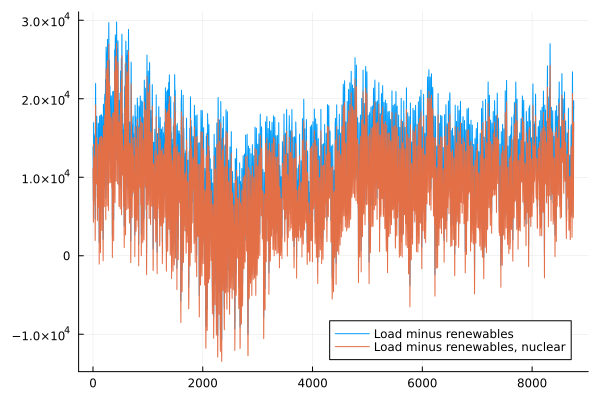

In [148]:
# plot(transpose(sum(load_data, dims=1)), label="Load")
plot(transpose(sum(load_data, dims=1) .- sum(solar_max, dims=1) .- sum(wind_max, dims=1)), label="Load minus renewables")
plot!(transpose(sum(load_data, dims=1) .- sum(solar_max, dims=1) .- sum(wind_max, dims=1) .- sum(nu_max, dims=1)), label="Load minus renewables, nuclear")

In [162]:
# Extract flow across interfaces
ifsum = zeros(n_if_lims,nt);

for i in 1:n_if_lims
    # Sum flow across the interfaces
    idx = if_lim_map[findall(==(i), if_lim_map[:, "IF_ID"]), "BUS_ID"]
    idx_signs = sign.(idx)
    idx_abs = abs.(idx)
    ifsum[i, :] = [sum(idx_signs .* flow_result[Int.(idx_abs), t]) for t in 1:nt] 
end

In [217]:
genprop

132×34 DataFrame
 Row │ GEN_NAME                           MODEL    STARTUP     SHUTDOWN  NCOST ⋯
     │ String                             Float64  Float64     Float64   Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ James A. FitzPatrick                   2.0   85890.0         0.0      2 ⋯
   2 │ Nine Mile Point 1                      2.0   63050.0         0.0      2
   3 │ Nine Mile Point 2                      2.0  124660.0         0.0      2
   4 │ Danskammer 1(2480,1)                   2.0    1501.85        0.0      2
   5 │ Danskammer 2(2480,2)                   2.0     947.637       0.0      2 ⋯
   6 │ Danskammer 3(2480,3)                   2.0    3350.41        0.0      2
   7 │ Danskammer 4(2480,4)                   2.0    2422.41        0.0      2
   8 │ Arthur Kill ST 2(2490,20)              2.0    3597.51        0.0      2
   9 │ Arthur Kill ST 3(2490,30)              2.0    5893.93        0.0      2 ⋯
  10 │ East River 1(2493,1)                   2.0    3521.9         0.0      2
  11 │ East River 2(2493,2)                   2.0    3423.94        0.0      2
  ⋮  │                 ⋮                     ⋮         ⋮          ⋮         ⋮  ⋱
 123 │ Solar farm                             2.0       0.0         0.0      2
 124 │ Solar farm                             2.0       0.0         0.0      2 ⋯
 125 │ HVDC_CSC                               2.0       0.0         0.0      2
 126 │ HVDC_Neptune                           2.0       0.0         0.0      2
 127 │ HVDC_VFT                               2.0       0.0         0.0      2
 128 │ HVDC_HTP                               2.0       0.0         0.0      2 ⋯
 129 │ HVDC_CSC                               2.0       0.0         0.0      2
 130 │ HVDC_Neptune                           2.0       0.0         0.0      2
 131 │ HVDC_VFT                               2.0       0.0         0.0      2
 132 │ HVDC_HTP                               2.0       0.0         0.0      2 ⋯
                                                 30 columns and 111 rows omitted

In [215]:
flow_result

94×8759 Matrix{Float64}:
  -377.949     -356.749     -327.101     …   -465.303     -440.116
  -152.051     -173.251     -202.899          -64.6967     -89.8836
   368.344      291.066      297.243          740.186      632.171
  1443.89      1279.64      1063.13          2058.25      1878.71
  -759.13      -772.366     -775.627        -1203.93     -1067.86
 -1431.05     -1155.09      -911.851     …  -2059.81     -1883.14
  -310.164     -248.468       -9.32987       -370.366     -345.261
  1449.18      1159.21       821.511         2300.0       2047.86
   569.492      495.747      387.286          898.593      804.676
   569.492      495.747      387.286          898.593      804.676
  -682.955     -764.565     -837.035     …   -918.594     -851.708
   -76.1756      -7.80051     61.4076        -285.339     -216.15
 -2023.79     -2047.15     -2069.18         -2226.1      -2215.16
     ⋮                                   ⋱               
   -38.5003      25.8006      24.5863         141.8

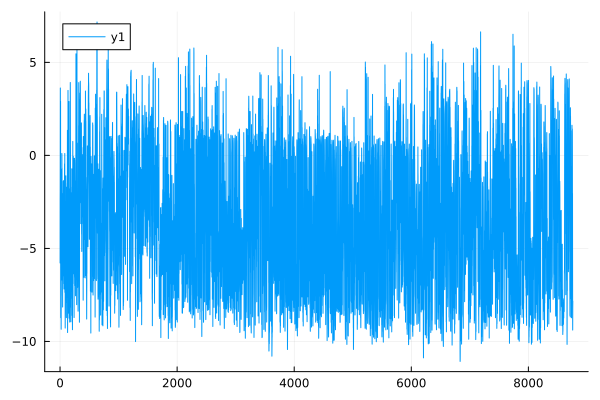

In [214]:
plot(flow_result[end, :])

In [47]:
plot(transpose(sum(load_shedding_result, dims=1)))

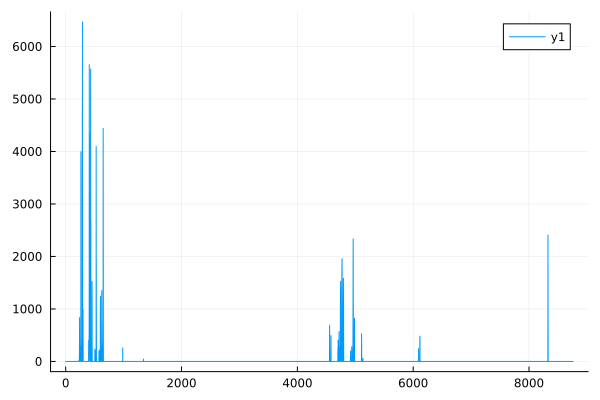

In [204]:
plot(transpose(sum(load_shedding_result, dims=1)))

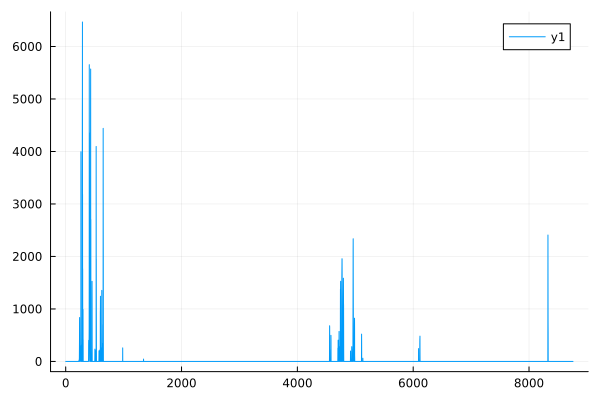

In [202]:
plot(transpose(sum(load_shedding_result, dims=1)))

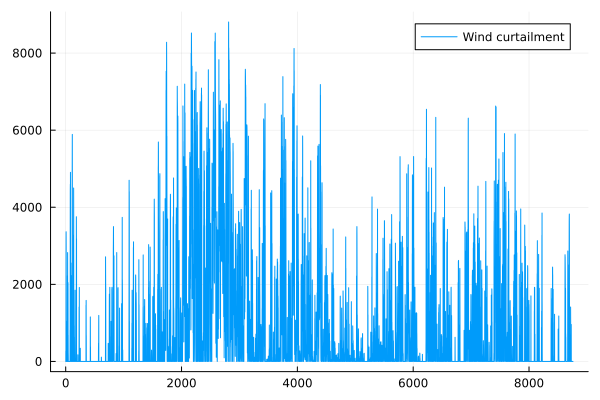

In [190]:
plot(transpose(sum(wind_curtail_result, dims=1)), label="Wind curtailment")

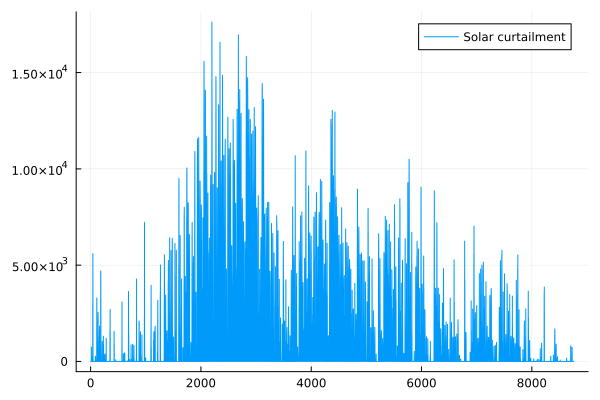

In [191]:
plot(transpose(sum(solar_curtail_result, dims=1)), label="Solar curtailment")

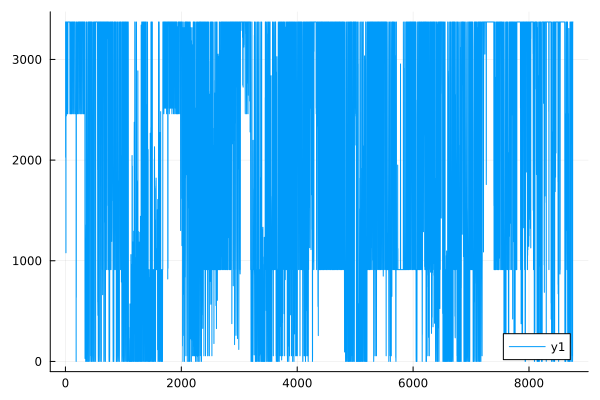

In [192]:
plot(transpose(sum(pg_result[findall(x -> x == "WAT", genprop[!, "FUEL_TYPE"]), :], dims=1)))

In [193]:
sum(pg_result[findall(x -> x == "NG", genprop[!, "FUEL_TYPE"]), :], dims=1)

1×8759 Matrix{Float64}:
 7507.84  7453.21  7453.21  7453.21  …  10402.8  10650.3  9660.34  9284.04

In [194]:
sum(pg_result[findall(x -> x == "UR", genprop[!, "FUEL_TYPE"]), :], dims=1)

1×8759 Matrix{Float64}:
 2736.0  2052.0  2052.0  2052.0  2052.0  …  2736.0  2736.0  2736.0  2736.0

In [195]:
sum(pg_result[findall(x -> x == "SolarUPV", genprop[!, "FUEL_TYPE"]), :], dims=1)

1×8759 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  5180.24  2847.89  403.326  0.0  0.0

In [196]:
sum(pg_result[findall(x -> x == "Wind", genprop[!, "FUEL_TYPE"]), :], dims=1)

1×8759 Matrix{Float64}:
 8503.81  8760.18  6879.79  7174.66  …  1383.89  1661.43  2846.34  4249.76

In [156]:
using Statistics

In [197]:
mean(sum(load_shedding_result, dims=1) .> 0.0)

0.027286219888115082

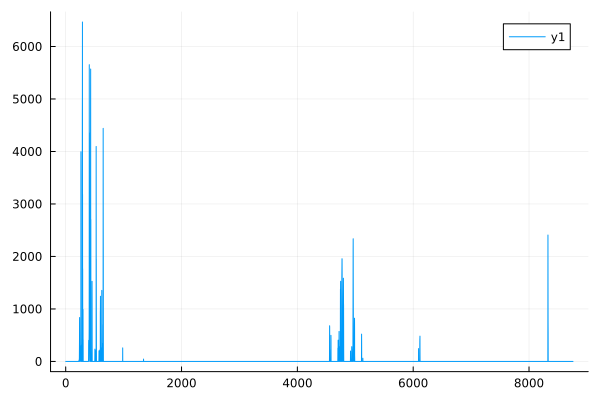

In [198]:
plot(transpose(sum(load_shedding_result, dims=1)))